In [1]:
def f(x):
    return 3*x**2 + 2*x + 10

In [12]:
h = 0.00000001
x = -1/4
(f(x+h) - f(x))/h

0.5000000413701855

In [61]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr__(self):
        return "Value(data={})".format(self.data)
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
        

In [66]:
a = Value(6.0, label='a')
b = Value(10.0, label='b')
c = Value(4.0, label='c')
e = a*b; e.label = 'e'
d = e + c ;d.label = 'd'

In [67]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s |data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

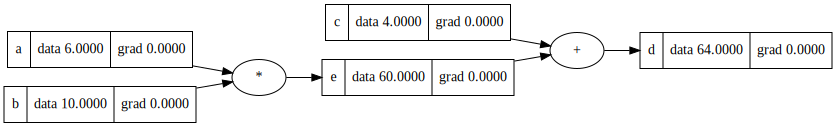

In [69]:
draw_dot(d)